In [1]:
import pandas as pd
import numpy as np
import easier as ezr
import lifelines as ll
import pymc3 as pm
pd.options.display.max_columns = 300
pd.options.display.max_rows = 300
%config Completer.use_jedi = False

In [2]:
class Loader(ezr.pickle_cache_mixin):
    
    pkc = ezr.pickle_cache_state('active')
    
    def __init__(self, which='treatment'):
        if which == 'treatment':
            self.tab = 'treatments'
        else:
            self.tab = 'starved'
            
    @ezr.pickle_cached_container()
    def df_feature_raw(self):
        gsheet = ezr.GSheet('pseudoscorpion_data_sheet', 'feature')
        df = gsheet.to_dataframe()
        df.columns = ezr.slugify(df.columns, kill_camel=True)
        df.loc[:, 'prefix'] = df.loc[:, 'prefix'].str.upper()
        df['sample_id'] = df.prefix + df.suffix.astype(str)
        df = df[[
            'sample_id',
            'sex',
            'lifestage'
        ]]
        return df
        
        
    
    
    @ezr.pickle_cached_container()
    def df_raw(self):
        gsheet = ezr.GSheet('pseudoscorpion_data_sheet', self.tab)
        df = gsheet.to_dataframe()
        df.columns = ezr.slugify(df.columns)
        return df
    
    @ezr.cached_container
    def df(self):
        df = self.df_raw
        
        df.loc[:, 'start_date'] = df.start_date.astype(np.datetime64)
        df = df.set_index(['id', 'trial', 'start_date'])
        df = df.T.reset_index().rename(columns={'index': 'observation_date'}).sort_index()
#         return df
        # df = df.sort_index(axis=1)
        df.iloc[:, 0] = (df.iloc[:, 0].str.replace('_', ' ') + ' 2020').astype(np.datetime64)
        df = df.replace(r'^\s*$', np.NaN, regex=True)
        # df = df.set_index[('observation_date', '')]
        df = df.set_index(('observation_date', '', np.NaN))

        df.index.name = 'date'

        lol = []
        for col_ind in range(df.shape[1]):
            ser = df.iloc[:, col_ind].dropna()
            sample_id = df.columns[col_ind][0]
            treatment = df.columns[col_ind][1]
            term_date = ser.index[-1]
            is_alive = ser[-1]
            start_date = df.columns[col_ind][-1]
            lol.append([sample_id, treatment, start_date, term_date, is_alive])

        dfx = pd.DataFrame(lol, columns=['sample_id', 'treatment', 'start_date', 'term_date', 'is_alive'])
        dfx['duration'] = (dfx.term_date - dfx.start_date).dt.days
        dfx['died'] = (1 - dfx.is_alive).astype(int)
        dfx.loc[:, 'sample_id'] = dfx.sample_id.str.strip().str.replace(r'\s+', '', regex=True)
        dfx.loc[:, 'treatment'] = dfx.treatment.str.strip().str.replace(r'\s+', '', regex=True)
        dfx = pd.merge(dfx, self.df_feature_raw, how='left', on='sample_id')
        
        # Include only one record for each sample for which there is feature information
        dfx = dfx.dropna()
        dfx = dfx.drop_duplicates('sample_id')
        
        # Only include adults with well-defined gender
        dfx = dfx[dfx.lifestage == 'adult']
        dfx = dfx[dfx.sex.isin(['male', 'female'])]
        
        # Default everyone's lower/upper bounds
        dfx['lower_bound'] = 0
        dfx['upper_bound'] = 100000
        
        # Set lower and upper bound for water treatments
        ind = (dfx.died == 1) & (dfx.treatment == 'W')
        dfx.loc[ind, 'upper_bound'] = dfx.loc[ind].duration
        ind = (dfx.died == 0) & (dfx.treatment == 'W')
        dfx.loc[ind, 'lower_bound'] = dfx.loc[ind].duration
        
        # Set lower and upper bound for heat treatments
        ind = (dfx.died == 1) & (dfx.treatment == 'H')
        dfx.loc[ind, 'upper_bound'] = dfx.loc[ind].duration
        dfx.loc[ind, 'lower_bound'] = dfx.loc[ind].duration - 1
        ind = (dfx.died == 0) & (dfx.treatment == 'H')
        dfx.loc[ind, 'lower_bound'] = dfx.loc[ind].duration
        
        # Set lower and upper bound for control treatments
        ind = (dfx.died == 1) & (dfx.treatment == 'C')
        dfx.loc[ind, 'upper_bound'] = dfx.loc[ind].duration
        dfx.loc[ind, 'lower_bound'] = dfx.loc[ind].duration - 1
        ind = (dfx.died == 0) & (dfx.treatment == 'C')
        dfx.loc[ind, 'lower_bound'] = dfx.loc[ind].duration
        
        # Limit to relevant fields
        dfx = dfx[[
            'sample_id',
            'duration',
            'lower_bound',
            'upper_bound',
            'treatment',
            'died',
            'sex',
            'lifestage',
        ]]
        return dfx
loader = Loader()     
df = loader.df
# df = df[df.sex == 'male']

# loader.df.sort_values('sample_id').head()
df.head()

,sample_id,duration,lower_bound,upper_bound,treatment,died,sex,lifestage
0,OC98,7,6,7,H,1,female,adult
1,OC93,26,26,100000,H,0,female,adult
2,OC92,26,26,100000,H,0,male,adult
3,OC78,26,26,100000,H,0,female,adult
4,OC73,1,0,1,H,1,male,adult


In [3]:
dfw = df[df.treatment == 'W']
dfh = df[df.treatment == 'H']
dfc = df[df.treatment == 'C']

In [4]:
def get_fitters(Fitter):
    fw = Fitter()
    fw.fit_interval_censoring(lower_bound=dfw.lower_bound, upper_bound=dfw.upper_bound, label='water')

    fh = Fitter()
    fh.fit_interval_censoring(lower_bound=dfh.lower_bound, upper_bound=dfh.upper_bound, label='heat')

    fc = Fitter()
    fc.fit_interval_censoring(lower_bound=dfc.lower_bound, upper_bound=dfc.upper_bound, label='control')
    return fw, fh, fc



Text(0, 0.5, 'surivival probability')

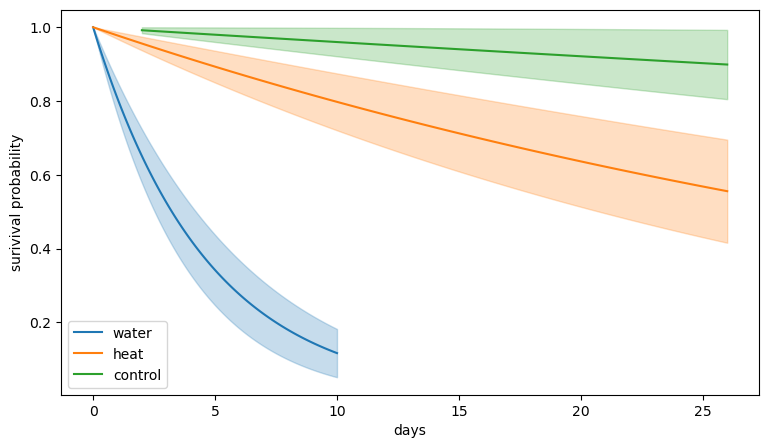

In [18]:
ax = ezr.figure() 

fw, fh, fc = get_fitters(ll.WeibullFitter)
fw, fh, fc = get_fitters(ll.ExponentialFitter)

fw.plot_survival_function(ax=ax)
fh.plot_survival_function(ax=ax)
fc.plot_survival_function(ax=ax)
ax.set_xlabel('days')
ax.set_ylabel('surivival probability')

# ax = ezr.figure() 
# fw.plot_hazard(ax=ax)
# fh.plot_hazard(ax=ax)
# fc.plot_hazard(ax=ax)
# ax.set_xlabel('days')
# ax.set_ylabel('hazard function')


In [19]:
def get_params(*fitters):
    df_list = []
    for fitter in fitters:
        dfp = fitter.summary
        dfp['treatment'] = fitter._label
        dfp.set_index('treatment', append=True, inplace=True)
        dfp = dfp.swaplevel(axis=0)
        df_list.append(dfp)
    return pd.concat(df_list)
get_params(fw, fh, fc)

,,coef,se(coef),coef lower 95%,coef upper 95%,z,p,-log2(p)
treatment,,,,,,,,
water,lambda_,4.662116,0.618893,3.449109,5.875123,5.917208,3.274518e-09,28.186070
heat,lambda_,44.260059,9.658550,25.329648,63.190469,4.478939,7.501489e-06,17.024392
control,lambda_,243.999610,121.999866,4.884267,483.114953,1.991802,4.639276e-02,4.429957
